In [7]:
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Literal
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

In [8]:
load_dotenv()

gen_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
eva_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
opt_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [14]:
class TweetState(TypedDict):
    topic: str
    tweet: str 
    evaluate: Literal["approved","needs_improvement"]
    iteration: int
    max_iter: int
    feedback: str

In [10]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [11]:
struc_eva_llm = eva_llm.with_structured_output(TweetEvaluation)

In [6]:
def gen_tweet(state: TweetState):

    prompt = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    output = gen_llm.invoke(prompt).content
    return {"tweet":output}

In [ ]:
def evaluate_tweet(state: TweetState):

    message = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality - Is this fresh, or have you seen it a hundred times before?  
    2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness - Is it short, sharp, and scroll-stopping?  
    4. Virality Potential - Would people retweet or share it?  
    5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"  
    - feedback: One paragraph explaining the strengths and weaknesses 
    """)
    ]
    
    response = struc_eva_llm.invoke(message)
    return {"evaluation":response.evaluation, "feedback": response.feedback}

In [13]:
def optimize_tweet(state: TweetState):

    message = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
        ]

    response = opt_llm.invoke(message).content
    iteration = state["iteration"]+1
    return {'tweet': response, 'iteration': iteration}

In [15]:
def route(state: TweetState)-> Literal["approved","needs_improvement"]:
    if state["evaluate"] == "approved":
        return "approved"
    else:
        return "needs_improvement"

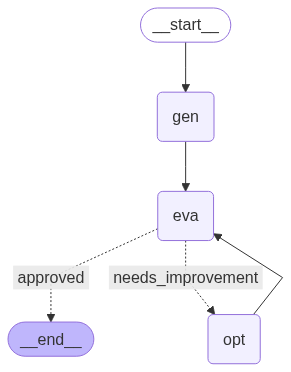

In [17]:
graph = StateGraph(TweetState)

graph.add_node("gen",gen_tweet)
graph.add_node("eva",evaluate_tweet)
graph.add_node("opt",optimize_tweet)

graph.add_edge(START,"gen")
graph.add_edge("gen","eva")
graph.add_conditional_edges("eva", route, {"approved":END, "needs_improvement":"opt"})
graph.add_edge("opt","eva")

workflow = graph.compile()

workflow



In [18]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

KeyError: 'evaluate'

In [ ]:
result